In [1]:
import os 

In [2]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot\\research'

In [3]:
os.chdir("../.")

In [4]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [5]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [6]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataTransformationConfig:
    """
    Data Transformation Configuration
    """
    root_dir: Path
    transformed_data_file: Path
    customer_path: Path
    product_path: Path
    train_data_file: Path
    test_data_file: Path
    target_column: str
    joined_data_file: Path

In [7]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories

In [8]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_data_transformation_config(self)-> DataTransformationConfig:
        """
        Returns Data Transformation Configuration
        """
        config = self.config.data_transformation
        schema =  self.schema.target_column
        
        create_directories([self.config.artifacts_root])
        
        data_transformation_config = DataTransformationConfig(
            root_dir=Path(config.root_dir),
            transformed_data_file= Path(config.transformed_data_file),
            product_path= Path(config.product_path),
            customer_path= Path(config.customer_path),
            train_data_file= Path(config.train_data_file),
            test_data_file= Path(config.test_data_file),
            target_column= schema.name,
            joined_data_file= Path(config.joined_data_file)
            )
        
        
        return data_transformation_config
    

In [9]:



import os  
from BankProducts import logger
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


     


In [10]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        #self.data = None
        #self.transformed_data = None
        
    def join_datasets(self):
        """
        Join customer and product datasets"""    
        try:
            customer_data = pd.read_csv(self.config.customer_path)
            product_data = pd.read_csv(self.config.product_path)

            # Ensure the directory for saving exists
            output_dir = os.path.dirname(self.config.transformed_data_file)
            os.makedirs(output_dir, exist_ok=True)

            # Join operation
            joined_data = pd.merge(customer_data, product_data, how="left",
                                left_on="existing_products", right_on="product_name")
            
            #drop unnecessary columns
            joined_data = joined_data.drop(columns=['existing_products'], errors='ignore')  # Drop columns which are not needed if it exists
            
            #check the dataset head
            print(joined_data.head())
            
            
            # Save the joined data
            try:   
                joined_data.to_csv(self.config.joined_data_file, index=False)
                logger.info(f"Joined dataset saved to {self.config.joined_data_file}")
                print(f"Joined dataset saved to {self.config.joined_data_file}")
            except Exception as e:
                logger.error(f"Error saving joined dataset: {e}")
                print(f"Error saving joined dataset: {e}")
            
            return joined_data

        except Exception as e:
            logger.error(f"Error in joining datasets: {e}")
            print(f"Error in joining datasets: {e}")
            raise e
    def transform_data(self):
        """
        Transform the data as per the requirements
        """
        
        # Load the data
        data = pd.read_csv(self.config.joined_data_file)
        # Perform transformations
        print(data.head())
        
        print(":"*100)
        
        data.info()
        print(":"*100)
        
        data.describe()
        print(":"*100)
        print(data.columns)
        print(":"*100)
        
        #drop na
        data.dropna(inplace=True
                            )
        #check null values
        print(data.isnull().sum())
        
        #check the number of  values in the target column
        print(data[self.config.target_column].value_counts())
        
        #resize the dataset to match the number of rows in the target column
        data = data[data[self.config.target_column].notnull()]
        
        #drop unnecessary columns
        data = data.drop(columns=[['customer_id','named', 'eligibility', 'description']], errors='ignore')
        
        
        #plot "product_name" histogram based of gender using seaborn
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=data, x= self.config.target_column, hue='gender', multiple='stack')

        # Add separated count labels above each segment
        for container in ax.containers:
            # Add offset so overlapping labels are vertically separated
            for bar in container:
                height = bar.get_height()
                if height > 0:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + height / 2,  # Place label at the middle of the segment
                        f'{int(height)}',
                        ha='center',
                        va='center',
                        fontsize=9,
                        color='white',  # or 'black' depending on your bar color
                        weight='bold'
                    )


        plt.title("Product Name Histogram by Gender")
        plt.tight_layout()
        plt.show()
                    
        #plot "age" histogram
        plt.figure(figsize=(10,6))
        plt.hist(data["age"], bins=10, edgecolor='black', color= "orange", alpha=0.7)
        plt.title("Age Frequency Distribution")
        plt.xlabel("Age")
        plt.ylabel("Frequency")
        plt.savefig("age_histogram.png")
        
    
        
        #plot "product_name" vs "age" bar plot
        plt.figure(figsize=(10,6))
        plt.bar(data["product_name"], data["age"], color="green")
        plt.title("Product Name vs Age Bar Plot")
        plt.xlabel("Product Name")
        plt.ylabel("Age")
        plt.savefig("product_name_vs_age_bar_plot.png")
        
        #feature selection
        # If it's a categorical variable like a string, correlation won't work correctly
        correlation_matrix = data.select_dtypes(include= ['float64', 'int64']).corr()
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
        plt.title("Correlation Matrix")
        plt.show()
        plt.savefig('correlation_matrix.png')
    
        # Save the data to a CSV file to the specified path
        os.makedirs(os.path.dirname(self.config.transformed_data_file), exist_ok=True)
        data.to_csv(self.config.transformed_data_file, index=False)
        logger.info(f"Transformed data saved to {self.config.transformed_data_file}")
        print(f"Transformed data saved to {self.config.transformed_data_file}")
        
        return data
      
    def split_data(self):
        data =  pd.read_csv(self.config.transformed_data_file)  
        
        #  splitting data into train and test sets
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
        
        
        #save train_data and test_data to csv files
        train_data.to_csv(os.path.join(self.config.train_data_file), index=False)
        test_data.to_csv(os.path.join(self.config.test_data_file), index=False)
        
        logger.info(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        print(f"Train and test sets saved to {self.config.train_data_file} and {self.config.test_data_file}")
        # Log the shapes of the train and test sets
        logger.info(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        #print the shapes of the train and test sets
        print(f"Train set shape: {train_data.shape}, Test set shape: {test_data.shape}")
        # Log the shapes of the train and test sets
        return train_data, test_data    
        
        
      

[2025-05-25 19:06:12,300: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-05-25 19:06:12,304: INFO: common: yaml file: params.yaml loaded successfully]
[2025-05-25 19:06:12,309: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-05-25 19:06:12,311: INFO: common: created directory at: artifacts]
[2025-05-25 19:06:12,312: INFO: common: created directory at: artifacts]
                            customer_id                   name  age  gender  \
0  a519e781-a936-41cd-bc8e-3891afd8cb27       Phyllis Jennings   29    Male   
1  205ef5ab-b315-42c6-ae05-5d9b26b9d8a2            Erika Moore   47    Male   
2  5e7d3a68-523b-4ac9-91b4-ea4791a81a80            Gary Spears   37  Female   
3  21a98f50-4c7a-4e2e-81cb-44ae99f96229  Kimberly Underwood MD   48  Female   
4  abd93c88-fe99-4462-9e9b-f742dab6d3bb         Trevor Rollins   23    Male   

                                    occupation  annual_income marital_status  \
0                                 Chirop

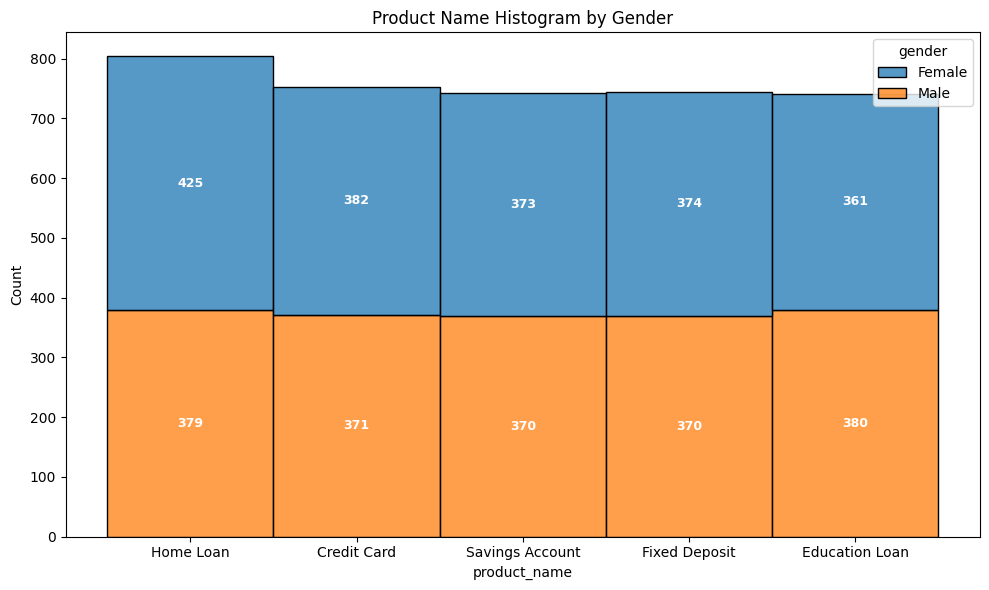

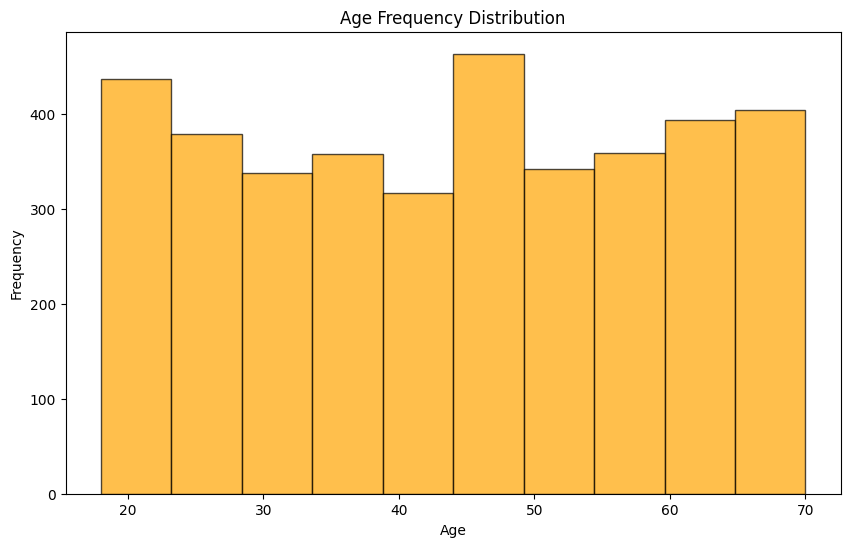

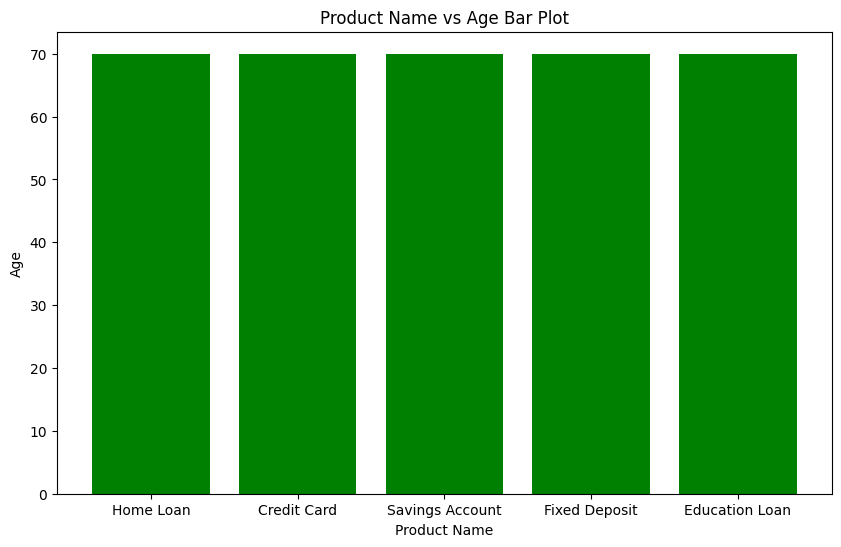

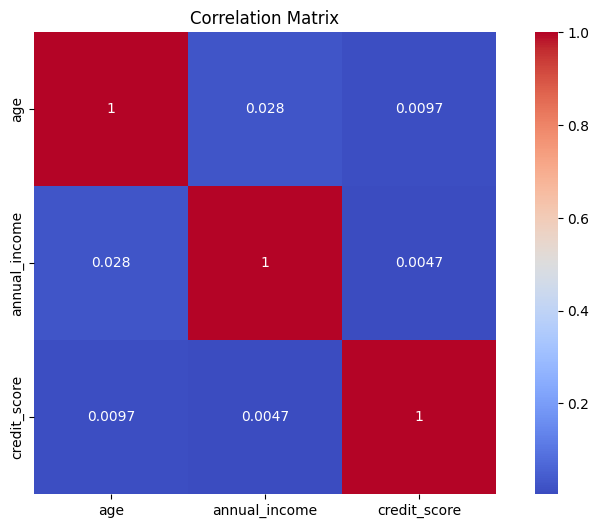

[2025-05-25 19:06:18,577: INFO: 144883891: Transformed data saved to artifacts\data_transformation\transformed_data.csv]
Transformed data saved to artifacts\data_transformation\transformed_data.csv
[2025-05-25 19:06:18,638: INFO: 144883891: Train and test sets saved to artifacts\data_transformation\train_data.csv and artifacts\data_transformation\test_data.csv]
Train and test sets saved to artifacts\data_transformation\train_data.csv and artifacts\data_transformation\test_data.csv
[2025-05-25 19:06:18,638: INFO: 144883891: Train set shape: (3028, 12), Test set shape: (757, 12)]
Train set shape: (3028, 12), Test set shape: (757, 12)


<Figure size 640x480 with 0 Axes>

In [11]:

try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    
    data_transformation = DataTransformation(config=data_transformation_config)
    
    data_transformation.join_datasets()
    data_transformation.transform_data()
    data_transformation.split_data()
    

except Exception as e:
    print(f"An error occurred: {e}")
    
    